In [1]:
# Import TensorFlow and necessary modules
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist

In [2]:
# Load the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [3]:
train_images=train_images.reshape((60000,28,28,1)).astype('float32')/255
test_images=test_images.reshape((10000,28,28,1)).astype('float32')/255

In [4]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [5]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [6]:
history = model.fit(train_images, train_labels, epochs=5, batch_size=64, validation_split=0.2)

Epoch 1/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 45s 53ms/step - accuracy: 0.8563 - loss: 0.4792 - val_accuracy: 0.9769 - val_loss: 0.0791
Epoch 2/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 54s 71ms/step - accuracy: 0.9803 - loss: 0.0602 - val_accuracy: 0.9852 - val_loss: 0.0497
Epoch 3/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 70s 54ms/step - accuracy: 0.9876 - loss: 0.0394 - val_accuracy: 0.9844 - val_loss: 0.0502
Epoch 4/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 61s 81ms/step - accuracy: 0.9900 - loss: 0.0323 - val_accuracy: 0.9872 - val_loss: 0.0429
Epoch 5/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 77s 74ms/step - accuracy: 0.9935 - loss: 0.0218 - val_accuracy: 0.9881 - val_loss: 0.0401


In [7]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy: {test_acc}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.9837 - loss: 0.0479
Test accuracy: 0.9879999756813049


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


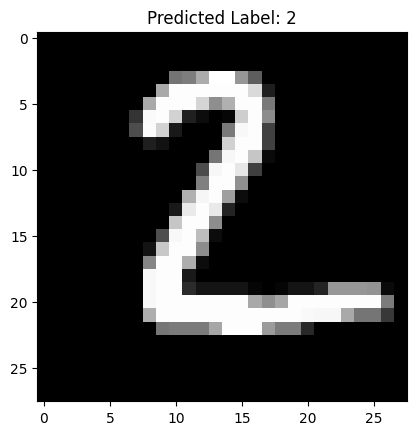

In [8]:
import numpy as np
import matplotlib.pyplot as plt
image_index = 1
test_image = test_images[image_index:image_index+1]
predictions = model.predict(test_image)
predicted_class = np.argmax(predictions)
plt.imshow(test_images[image_index].reshape(28, 28), cmap='gray')
plt.title(f"Predicted Label: {predicted_class}")
plt.show()

In [9]:
from scipy.ndimage import rotate, shift
# Function to add Gaussian noise
def add_noise(images, noise_factor=0.5):
    noisy = images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    noisy = np.clip(noisy, 0., 1.)  # keep pixels between 0 and 1
    return noisy

# Function to randomly rotate images
def rotate_images(images, max_angle=30):
    rotated = np.zeros_like(images)
    for i in range(images.shape[0]):
        angle = np.random.uniform(-max_angle, max_angle)
        rotated[i, :, :, 0] = rotate(images[i, :, :, 0], angle=angle, reshape=False, mode='nearest')
    return rotated

# Function to apply both noise and rotation
def add_noise_and_rotate(images):
    noisy_images = add_noise(images, noise_factor=0.5)
    noisy_rotated_images = rotate_images(noisy_images)
    return noisy_rotated_images

In [10]:
#Creating Anomalies in Data
num_anomalies = 2000

random_idx = np.random.choice(test_images.shape[0], num_anomalies, replace=False)
normal_samples = test_images[random_idx]

anomaly_noise = add_noise(normal_samples)
anomaly_rotated = rotate_images(normal_samples)
anomaly_noise_rotated = add_noise_and_rotate(normal_samples)

anomalous_images = np.concatenate((anomaly_noise, anomaly_rotated, anomaly_noise_rotated), axis=0)
anomalous_labels = np.full(anomalous_images.shape[0], -1)  # Label anomalies with -1

normal_labels = np.zeros(test_images.shape[0])

X_full = np.concatenate((test_images, anomalous_images), axis=0)
y_full = np.concatenate((normal_labels, anomalous_labels), axis=0)

print(f"Normal samples: {test_images.shape[0]}")
print(f"Anomalous samples: {anomalous_images.shape[0]}")
print(f"Total samples after mixing: {X_full.shape[0]}")

Normal samples: 10000
Anomalous samples: 6000
Total samples after mixing: 16000


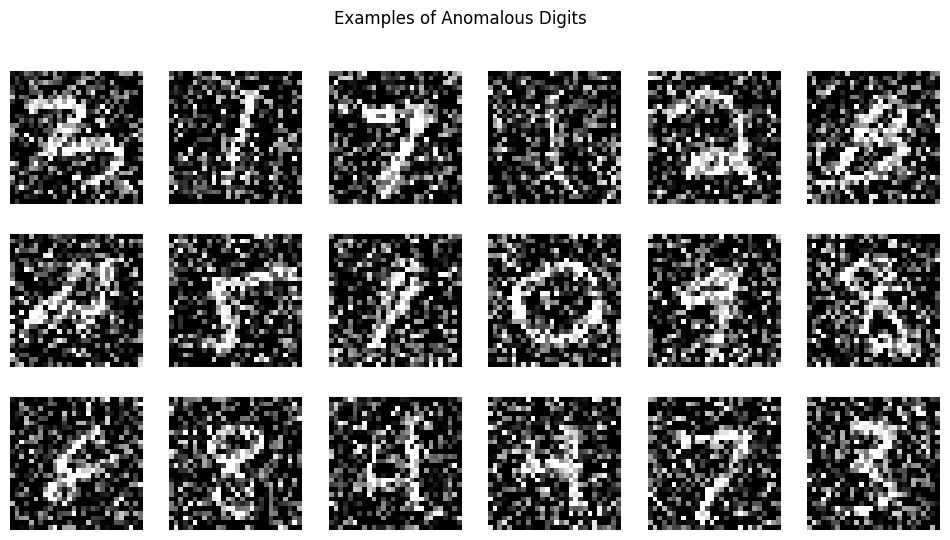

In [11]:
#Visualizing the created Anomalies
fig, axes = plt.subplots(3, 6, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(anomalous_images[i].reshape(28,28), cmap='gray')
    ax.axis('off')
plt.suptitle('Examples of Anomalous Digits')
plt.show()

In [12]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Flatten, Reshape

#Creating a autoencoder
input_img = Input(shape=(28,28,1))

x = Flatten()(input_img)
encoded = Dense(128, activation='relu')(x)
encoded = Dense(64, activation='relu')(encoded)

decoded = Dense(128, activation='relu')(encoded)
decoded = Dense(28*28, activation='sigmoid')(decoded)
decoded = Reshape((28,28,1))(decoded)

autoencoder = Model(input_img, decoded)

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 784)                 │         101,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 28, 28, 1)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 218,192 (852.31 KB)

 Trainable params: 218,192 (852.31 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
#Training the model on Mnist dataset
normal_idx = np.where(y_full == 0)[0]
X_train_normal = X_full[normal_idx]

# Train the autoencoder
history = autoencoder.fit(X_train_normal, X_train_normal,
                          epochs=20,
                          batch_size=256,
                          shuffle=True,
                          validation_split=0.2)

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 0.5466 - val_loss: 0.2825
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.2613 - val_loss: 0.2453
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.2241 - val_loss: 0.2101
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1958 - val_loss: 0.1854
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1745 - val_loss: 0.1676
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1595 - val_loss: 0.1561
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.1479 - val_loss: 0.1475
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1399 - val_loss: 0.1406
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1330 - val_loss: 0.1348
Epoch 10/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1279 - val_loss: 0.1291
Epoch 11/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1221 - val_loss: 0.1252
Epoch 12/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1

In [14]:
# Predict reconstructed images for all samples (normal + anomalies)
reconstructed = autoencoder.predict(X_full)

# Calculate mean squared error
mse = np.mean(np.power(X_full - reconstructed, 2), axis=(1,2,3))

#Some reconstruction errors
print("Sample reconstruction errors:", mse[:5])

500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Sample reconstruction errors: [0.00598288 0.01404026 0.00359552 0.00722728 0.01092099]


In [15]:
# Set threshold - here simple: mean + 3*std of normal samples error
threshold = np.mean(mse[normal_idx]) + 3 * np.std(mse[normal_idx])
print("Anomaly detection threshold:", threshold)

y_pred = (mse > threshold).astype(int)

y_true = (y_full == -1).astype(int)

Anomaly detection threshold: 0.0338581185774548


In [16]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

print("Classification Report:\n", classification_report(y_true, y_pred))

roc_score = roc_auc_score(y_true, mse)
print(f"ROC-AUC Score: {roc_score:.4f}")

Confusion Matrix:
 [[9922   78]
 [1890 4110]]
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.99      0.91     10000
           1       0.98      0.69      0.81      6000

    accuracy                           0.88     16000
   macro avg       0.91      0.84      0.86     16000
weighted avg       0.89      0.88      0.87     16000

ROC-AUC Score: 0.8660


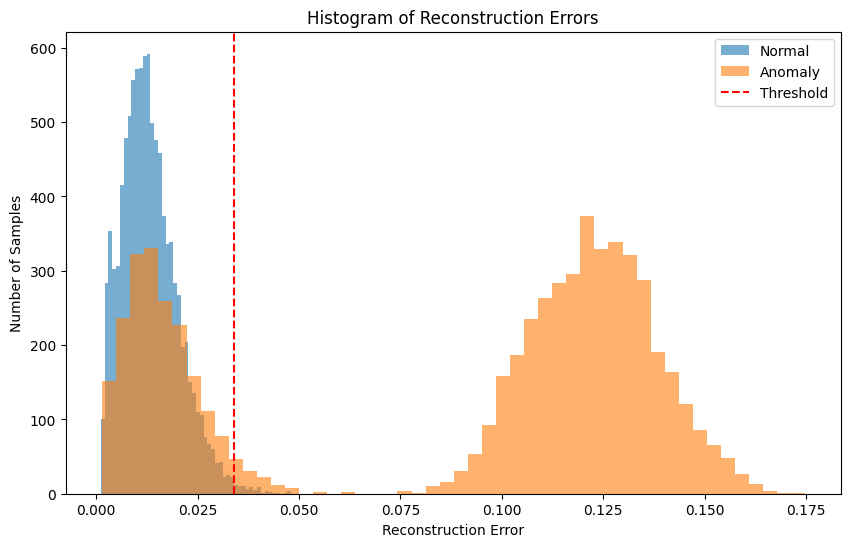

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.hist(mse[y_true==0], bins=50, alpha=0.6, label='Normal')
plt.hist(mse[y_true==1], bins=50, alpha=0.6, label='Anomaly')
plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
plt.legend()
plt.xlabel('Reconstruction Error')
plt.ylabel('Number of Samples')
plt.title('Histogram of Reconstruction Errors')
plt.show()

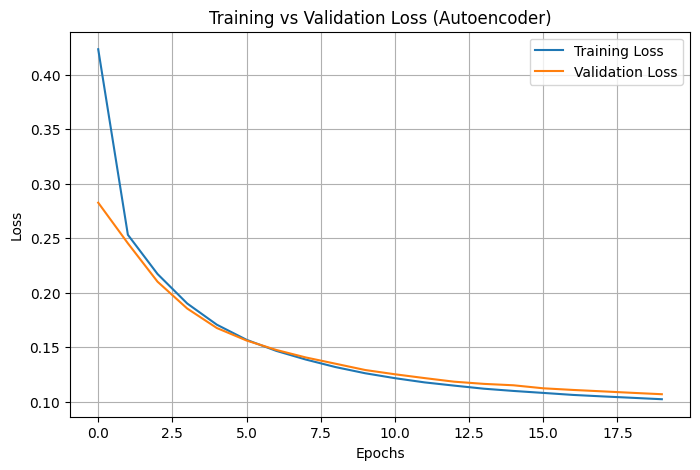

In [18]:
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss (Autoencoder)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

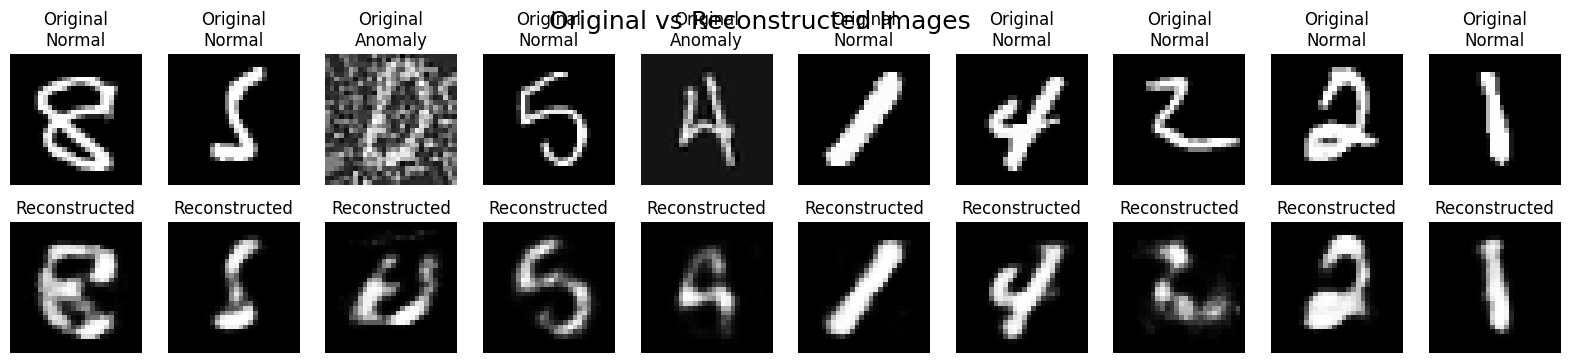

In [19]:
import numpy as np

sample_idx = np.random.choice(len(X_full), 10)

plt.figure(figsize=(20, 4))
for i, idx in enumerate(sample_idx):
    # Original
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(X_full[idx].reshape(28,28), cmap='gray')
    plt.title(f"Original\n{'Normal' if y_full[idx]==0 else 'Anomaly'}")
    plt.axis('off')
    
    # Reconstructed
    ax = plt.subplot(2, 10, i + 1 + 10)
    plt.imshow(reconstructed[idx].reshape(28,28), cmap='gray')
    plt.title(f"Reconstructed")
    plt.axis('off')
    
plt.suptitle("Original vs Reconstructed Images", fontsize=18)
plt.show()